In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Below is an example of using the SLATM$_d^2$ reaction representations for the GDB7 dataset.

In [2]:
import os
import pickle as pkl
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns

In [3]:
from src.reaction_reps import QML, B2R2
from src.learning import learning_curve, predict_KRR

In [4]:
def polyfit(train_sizes, maes):
    m, c = np.polyfit(np.log(train_sizes), np.log(maes), 1)
    polyfit = np.exp(m * np.log(train_sizes) + c)
    return polyfit

In [5]:
start = time.time()
b2r2 = B2R2()
b2r2.get_gdb7_rxn_data()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 7.2 seconds


In [6]:
energies = b2r2.barriers
pd.DataFrame(energies).describe()

,0
count,11961.000000
mean,83.392466
std,22.755110
min,10.727258
25%,67.287048
50%,81.519704
75%,97.646429
max,204.654825


In [7]:
# takes about 15 min when not pickled
filename = 'GDB7_b2r2_l.pkl'
if os.path.exists(f'{filename}'):
    with open(f'{filename}', 'rb') as f:
        b2r2_l = pkl.load(f)
else:
    start = time.time()
    b2r2_l = b2r2.get_b2r2_l(Rcut=6)
    with open(f'{filename}', 'wb') as f:
        pkl.dump(b2r2_l, f)
    print(f'Elapsed time: {time.time() - start:.1f} seconds')

In [8]:
start = time.time()
qml = QML()
qml.get_gdb7_rxn_data()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 12.9 seconds


# Reproduce Figure 4
- SLATM$_d^{(2)}$ 
- `get_SLATM_twobody()` function [link](https://github.com/lcmd-epfl/b2r2-reaction-rep/blob/master/src/reaction_reps.py#L601)

In [9]:
start = time.time()
slatm_2_r, slatm_2_p, slatm_2_d = qml.get_SLATM_twobody()
print(f'Elapsed time: {time.time() - start:.1f} seconds')

Elapsed time: 135.6 seconds


Start by calling their `learning_curve` function.

Must use the hyperparameters that they report in the SI for the GDB7 dataset i.e. $\sigma = 10$ and $\lambda$ = 1e-4

In [10]:
start = time.time()
train_sizes, mean_maes, stdev = learning_curve(slatm_2_d, energies, CV=10, sigma=10, l2reg=1e-4)
print(f'Elapsed time: {time.time() - start:.1f} seconds')

CV iteration 0
CV iteration 1
CV iteration 2
CV iteration 3
CV iteration 4
CV iteration 5
CV iteration 6
CV iteration 7
CV iteration 8
CV iteration 9
Elapsed time: 881.1 seconds


In [11]:
train_sizes

[1076, 1914, 3404, 6053, 10765]

In [12]:
mean_maes

array([15.11638906, 13.56011588, 11.97437725, 10.86092365,  9.89202551])

In [13]:
stdev

array([0.43744217, 0.59717903, 0.28681904, 0.39050575, 0.36949154])

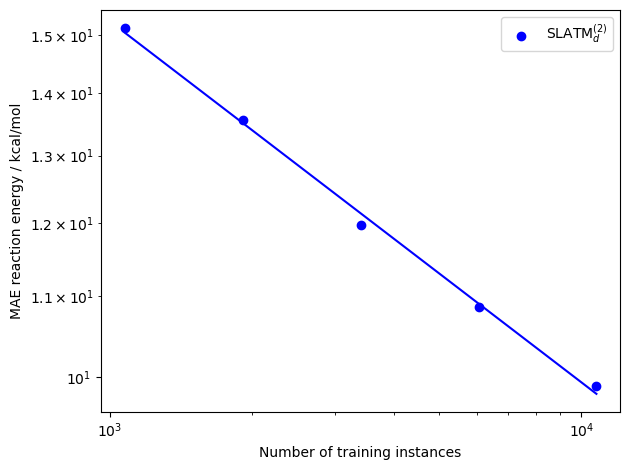

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(train_sizes, mean_maes, color='blue', label='SLATM$_d^{(2)}$')
ax.plot(train_sizes, polyfit(train_sizes, mean_maes), color='blue')

ax.set_xlabel("Number of training instances")
ax.set_ylabel("MAE reaction energy / kcal/mol")
plt.legend()
plt.tight_layout()
plt.show()

Rewrite the `learning_curve` [function](https://github.com/lcmd-epfl/b2r2-reaction-rep/blob/master/src/learning.py#L61) so that it does train, val, test split. Technically, we should use the validation set to optimized the hyperparameters, but here, we simply use the published set of hyperparameters from van Gerwen et al. We also specify the random seeds so results are reproducible.

In [15]:
def learning_curve_updated(X, y, CV=5, n_points=5, seed=100, sigma=1, l2reg=1e-6):
    # 0 is the smallest training size, n_points is the largest size
    splits = {i: [] for i in range(n_points)}
    preds = {i: [] for i in range(n_points)}
    targets = {i: [] for i in range(n_points)}
    
    train_fractions = np.logspace(-1, 0, num=n_points, endpoint=True)

    maes = np.zeros((CV, n_points))
    
    for i, seed in enumerate(range(CV)):
        print('*'*88)
        print("CV iteration", i)

        # create 85:5:10 split
        # by default, shuffle=True
        # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
        train_indices, test_indices, _, _ = train_test_split(np.arange(len(y)), y, test_size=0.15, random_state=seed)
        val_indices, test_indices, _, _ = train_test_split(test_indices, test_indices, test_size=2/3, random_state=seed)
        
        print(f'train_indices.shape: {train_indices.shape}')
        print(f'val_indices.shape: {val_indices.shape}')
        print(f'test_indices.shape: {test_indices.shape}')
        train_sizes = [int(len(train_indices) * x) for x in train_fractions]
        print(f'train_sizes: {train_sizes}')

        for j, train_size in enumerate(train_sizes):
            train_indices_tmp = train_indices[:train_size]
            
            # append subsplits for this fold
            splits[j].append([train_indices_tmp, val_indices, test_indices])
            X_train = X[train_indices_tmp]
            y_train = y[train_indices_tmp]
            X_test = X[test_indices]
            y_test = y[test_indices]                                       
                                                             
            mae, y_pred = predict_KRR(X_train, X_test, y_train, y_test, sigma=sigma, l2reg=l2reg)
            preds[j].append(y_pred)
            targets[j].append(y_test)
            maes[i, j] = mae
        
    return train_sizes, splits, preds, targets, maes

In [16]:
# takes about 2 min for each CV iteration
start = time.time()
train_sizes, splits, preds, targets, maes = learning_curve_updated(slatm_2_d, energies, CV=5, sigma=10, l2reg=1e-4)
print(f'Elapsed time: {time.time() - start:.1f} seconds')

****************************************************************************************
CV iteration 0
train_indices.shape: (10166,)
val_indices.shape: (598,)
test_indices.shape: (1197,)
train_sizes: [1016, 1807, 3214, 5716, 10166]
****************************************************************************************
CV iteration 1
train_indices.shape: (10166,)
val_indices.shape: (598,)
test_indices.shape: (1197,)
train_sizes: [1016, 1807, 3214, 5716, 10166]
****************************************************************************************
CV iteration 2
train_indices.shape: (10166,)
val_indices.shape: (598,)
test_indices.shape: (1197,)
train_sizes: [1016, 1807, 3214, 5716, 10166]
****************************************************************************************
CV iteration 3
train_indices.shape: (10166,)
val_indices.shape: (598,)
test_indices.shape: (1197,)
train_sizes: [1016, 1807, 3214, 5716, 10166]
********************************************************************

In [17]:
train_sizes

[1016, 1807, 3214, 5716, 10166]

In [18]:
maes

array([[15.76252655, 14.31841049, 12.27019986, 10.76153489,  9.87542626],
       [15.85105886, 12.89486858, 11.83772153, 10.85053551,  9.91353425],
       [15.37387864, 13.62687956, 11.91487975, 10.56608872,  9.91369647],
       [15.66667587, 13.9759413 , 12.69399708, 11.59993732, 10.31947603],
       [14.70636627, 12.6512138 , 11.46897873, 10.83440395, 10.05001658]])

In [19]:
for train, val, test in splits[1]:
    print('*'*88)
    print(train.shape)
    print(val.shape)
    print(test.shape)

****************************************************************************************
(1807,)
(598,)
(1197,)
****************************************************************************************
(1807,)
(598,)
(1197,)
****************************************************************************************
(1807,)
(598,)
(1197,)
****************************************************************************************
(1807,)
(598,)
(1197,)
****************************************************************************************
(1807,)
(598,)
(1197,)


Pickle the results

In [20]:
with open('GDB7_random_splits.pkl', 'wb') as f:
    pkl.dump(splits, f)

In [21]:
for i, train_size in enumerate(train_sizes):
    folds = []
    for train, val, test in splits[i]:
        # train = train[:train_size]
        assert len(train) == train_size
        folds.append([train, val, test])
    with open(f'data/GDB7-20-TS/GDB7_random_split_indices_train_size_{train_size}.pkl', 'wb') as f:
        pkl.dump(folds, f)

In [22]:
with open('GDB7_random_splits_predictions.pkl', 'wb') as f:
    pkl.dump(preds, f)

In [23]:
with open('GDB7_random_splits_targets.pkl', 'wb') as f:
    pkl.dump(targets, f)

In [24]:
with open('GDB7_random_splits_maes.pkl', 'wb') as f:
    pkl.dump(maes, f)

Load the results

In [25]:
with open('GDB7_random_splits.pkl', 'rb') as f:
    splits = pkl.load(f)

In [26]:
with open('GDB7_random_splits_predictions.pkl', 'rb') as f:
    preds = pkl.load(f)

In [27]:
with open('GDB7_random_splits_targets.pkl', 'rb') as f:
    targets = pkl.load(f)

In [28]:
with open('GDB7_random_splits_maes.pkl', 'rb') as f:
    maes = pkl.load(f)

The predictions are centered at 0 which is good. But some of these predictions have enormous errors.
- When using only 1016 training reactions, the test predictions have some differences that are off by 100-200 kcal/mol
- Even when using all 10,166 training reactions, still some test predictions are off by 70-135 kcal/mol

****************************************************************************************
training size had 1016 examples
test size was 1197
Ea MAE: 15.762527 kcal/mol
min: -204.04 kcal/mol	 max: 132.13 kcal/mol
mean: 0.87 kcal/mol	 std: 23.10 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1197
Ea MAE: 15.851059 kcal/mol
min: -111.97 kcal/mol	 max: 147.69 kcal/mol
mean: -0.99 kcal/mol	 std: 23.18 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1197
Ea MAE: 15.373879 kcal/mol
min: -91.45 kcal/mol	 max: 136.73 kcal/mol
mean: -0.11 kcal/mol	 std: 22.03 kcal/mol
****************************************************************************************
training size had 1016 examples
test size was 1197
Ea MAE: 15.666676 kcal/mol
min: -117.27 kcal/mol	 max: 149.34 kcal/mol
mean: 1.07 kcal/mol	 std: 23.60 

Text(0.5, 0, 'Error (kcal/mol)')

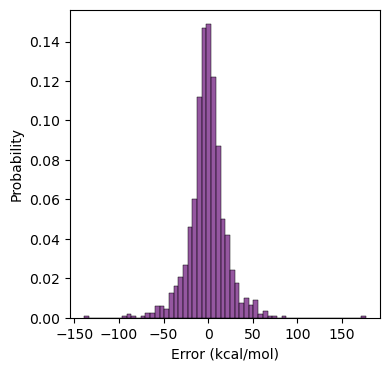

In [29]:
color = '#721f81'  # dark purple
ii = 0
f, ax = plt.subplots(figsize=(4, 4))
for pred, target in zip(preds[ii], targets[ii]):
    print('*'*88)
    print(f'training size had {len(splits[ii][0][0])} examples')
    # make sure the testing size is the same 
    assert len(splits[ii][0][2]) == len(pred)
    print(f'test size was {len(pred)}')
    mae = mean_absolute_error(target, pred.flatten())
    print(f'Ea MAE: {mae:.6f} kcal/mol')
    
    residuals = target - pred.flatten()
    print(f'min: {np.min(residuals):.2f} kcal/mol\t max: {np.max(residuals):.2f} kcal/mol')
    print(f'mean: {np.mean(residuals):.2f} kcal/mol\t std: {np.std(residuals):.2f} kcal/mol')

# just plot a histogram for the last results
sns.histplot(residuals, 
             color=color,
             bins=60, stat='probability', edgecolor="k")

ax.set_xlabel('Error (kcal/mol)')

****************************************************************************************
training size had 10166 examples
test size was 1197
Ea MAE: 9.875426 kcal/mol
min: -75.01 kcal/mol	 max: 116.10 kcal/mol
mean: 0.36 kcal/mol	 std: 14.59 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1197
Ea MAE: 9.913534 kcal/mol
min: -72.27 kcal/mol	 max: 81.89 kcal/mol
mean: -0.14 kcal/mol	 std: 14.67 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1197
Ea MAE: 9.913696 kcal/mol
min: -87.36 kcal/mol	 max: 75.06 kcal/mol
mean: 0.27 kcal/mol	 std: 14.69 kcal/mol
****************************************************************************************
training size had 10166 examples
test size was 1197
Ea MAE: 10.319476 kcal/mol
min: -86.85 kcal/mol	 max: 136.17 kcal/mol
mean: 0.15 kcal/mol	 std: 15.56 kcal/

Text(0.5, 0, 'Error (kcal/mol)')

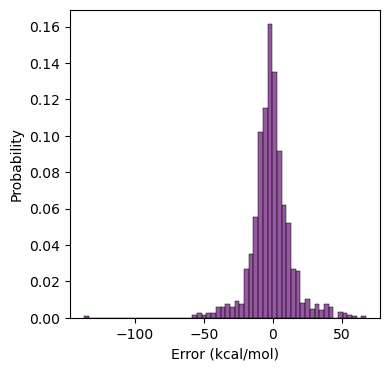

In [30]:
color = '#721f81'  # dark purple
ii = 4
f, ax = plt.subplots(figsize=(4, 4))
for pred, target in zip(preds[ii], targets[ii]):
    print('*'*88)
    print(f'training size had {len(splits[ii][0][0])} examples')
    # make sure the testing size is the same 
    assert len(splits[ii][0][2]) == len(pred)
    print(f'test size was {len(pred)}')
    mae = mean_absolute_error(target, pred.flatten())
    print(f'Ea MAE: {mae:.6f} kcal/mol')
    
    residuals = target - pred.flatten()
    print(f'min: {np.min(residuals):.2f} kcal/mol\t max: {np.max(residuals):.2f} kcal/mol')
    print(f'mean: {np.mean(residuals):.2f} kcal/mol\t std: {np.std(residuals):.2f} kcal/mol')

# just plot a histogram for the last results
sns.histplot(residuals, 
             color=color,
             bins=60, stat='probability', edgecolor="k")

ax.set_xlabel('Error (kcal/mol)')

In [31]:
mae_slatm_2_d = np.mean(maes, axis=0)
std_slatm_2_d = np.std(maes, axis=0)

In [32]:
mae_slatm_2_d

array([15.47210124, 13.49346275, 12.03715539, 10.92250008, 10.01442992])

In [33]:
std_slatm_2_d

array([0.41516569, 0.63226935, 0.41552392, 0.35349678, 0.16368795])

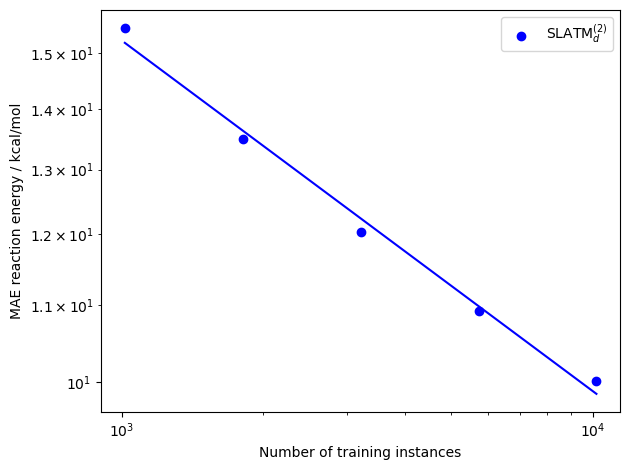

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xscale('log')
ax.set_yscale('log')

ax.scatter(train_sizes, mae_slatm_2_d, color='blue', label='SLATM$_d^{(2)}$')
ax.plot(train_sizes, polyfit(train_sizes, mae_slatm_2_d), color='blue')

ax.set_xlabel("Number of training instances")
ax.set_ylabel("MAE reaction energy / kcal/mol")
plt.legend()
plt.tight_layout()
plt.show()